# Beer recommendations

Develops both content-based and collaborative filtering recommendation systems from web-scraped BeerAdvocate data.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim import corpora, models, similarities, matutils

sns.set_style('whitegrid')

%matplotlib inline

In [21]:
def get_topical_terms(topic_mat, topic_num, term_vec, num_terms=25):
    return term_vec[np.argsort(-topic_mat[topic_num,:])][:num_terms]

## Check topics with saison before using on larger dataset

In [67]:
saison_beer_df = pd.read_csv('saison_beer_info.csv')
saison_user_df = pd.read_csv('saison_user_info.csv')
saison_text_df = pd.read_csv('saison_text_info.csv')

In [45]:
vectorizer = CountVectorizer(min_df=5, max_df=0.6, stop_words = 'english')
count_mat = vectorizer.fit_transform(saison_text_df.text)

In [46]:
pd.DataFrame(count_mat.toarray(),  columns=vectorizer.get_feature_names()).head(10)

,00,000,001,002,003,004,005,006,007,008,...,zesty,zinfandel,zing,zingy,zip,zippy,zone,zoo,zwanze,øl
0,1,0,0,0,0,0,0,0,0,1,...,1,0,2,1,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,2,0,0,1,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,5,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,1,1,0,...,7,0,0,0,0,1,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,11,0,0,0,1,2,0,0,0,0
6,2,1,0,0,0,0,0,0,0,1,...,6,0,0,0,1,0,0,0,0,0
7,1,0,0,0,0,0,1,0,0,0,...,8,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,1,0,0,...,2,0,0,0,0,0,0,0,0,0


### Latent Semantic Analysis

In [47]:
lsa = TruncatedSVD(50)
reduced_mat = lsa.fit_transform(count_mat)

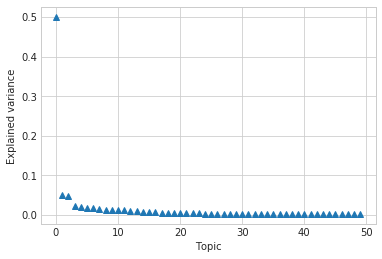

In [48]:
fig, ax = plt.subplots()
ax.plot(lsa.explained_variance_ratio_,'^')
ax.set_ylabel("Explained variance")
ax.set_xlabel("Topic");

In [43]:
terms = np.array(vectorizer.get_feature_names())

In [44]:
for i in range(5):
    print("topic {}".format(i))
    print(get_topical_terms(lsa.components_,i,terms, 35))

topic 0
['hops' 'pepper' 'belgian' 'spicy' 'brett' 'sour' 'floral' 'earthy' 'wheat'
 'funky' 'pale' 'hop' 'slight' 'bitterness' 'honey' 'apple' 'sweetness'
 'mild' 'refreshing' 'straw' 'character' 'poured' 'herbal' 'spices'
 'moderate' 'wine' 'touch' 'banana' 'finger' 'grassy' 'yeasty' 'peppery'
 'lots' 'clove' 'bitter']
topic 1
['brett' 'oak' 'wine' 'sour' 'barrel' 'tartness' 'funky' 'peach' 'cherry'
 'barrels' 'aged' '20164' 'acidity' '2016' 'red' 'grape' 'vinous' '20154'
 'casey' 'chardonnay' 'wood' 'lactic' 'wild' 'sourness' 'acidic' '20174'
 'grapes' 'apricot' 'oaky' 'batch' 'farmstead' 'hill' 'cherries' 'bretty'
 '2015']
topic 2
['dark' 'chocolate' 'brown' 'coffee' 'roasted' 'black' 'caramel' 'cherry'
 'red' 'roast' 'tan' 'cherries' 'cocoa' 'fantome' 'amber' 'roasty' 'sour'
 'interesting' 'stout' 'licorice' 'sugar' 'deep' 'plum' 'reddish' 'ruby'
 'toffee' 'porter' 'fig' 'raisin' 'khaki' 'spices' 'malts' 'cola' 'unique'
 '20113']
topic 3
['placeholder' '2014' '2016' '2015' 'compan

First three topics look like they could be useful. Topic 0 looks like a typical saison, and Topic 1 looks like a barrel-aged sour saison. Topic 2 is especially interesting, because it probably refers to a relatively rare substyle of saison (dark saison).

### Latent Dirichlet Allocation

In [50]:
count_mat_T = count_mat.transpose()
corpus = matutils.Sparse2Corpus(count_mat_T)

In [51]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [52]:
lda = models.LdaModel(corpus=corpus, num_topics=6, id2word=id2word, passes=10)

In [53]:
lda.print_topics(num_words=15)

[(0,
  '0.018*"dark" + 0.010*"brown" + 0.007*"black" + 0.006*"belgian" + 0.006*"caramel" + 0.006*"chocolate" + 0.005*"spicy" + 0.005*"malts" + 0.004*"interesting" + 0.004*"roasted" + 0.004*"amber" + 0.004*"earthy" + 0.004*"pepper" + 0.004*"hops" + 0.004*"sour"'),
 (1,
  '0.010*"brett" + 0.010*"sour" + 0.009*"wine" + 0.008*"oak" + 0.006*"tartness" + 0.006*"funky" + 0.004*"peach" + 0.004*"floral" + 0.004*"barrel" + 0.004*"earthy" + 0.004*"mild" + 0.004*"slight" + 0.004*"character" + 0.004*"bright" + 0.003*"apple"'),
 (2,
  '0.008*"belgian" + 0.008*"hops" + 0.007*"pepper" + 0.007*"spicy" + 0.004*"bitterness" + 0.004*"banana" + 0.004*"wheat" + 0.004*"pale" + 0.004*"sweetness" + 0.004*"refreshing" + 0.004*"clove" + 0.004*"slight" + 0.004*"spices" + 0.004*"finger" + 0.004*"yeasty"'),
 (3,
  '0.017*"brett" + 0.007*"hops" + 0.006*"funky" + 0.005*"sour" + 0.005*"cucumber" + 0.004*"floral" + 0.004*"grapefruit" + 0.004*"bitterness" + 0.004*"pumpkin" + 0.004*"pepper" + 0.004*"poured" + 0.004*"refr

Took a lot of CPU clock time to run (cost me $0.50 on AWS!) and didn't really produce better results than LSA.

### Add topics 0, 1, and 2 from LSA as features to saison beer

In [68]:
saison_beer_df['topic_0'] = reduced_mat[:, 0]

In [69]:
saison_beer_df['topic_1'] = reduced_mat[:, 1]

In [70]:
saison_beer_df['topic_2'] = reduced_mat[:, 2]

In [71]:
saison_beer_df.head()

,abv,avg_score,beer,beer_ba_id,brewery,brewery_ba_id,gots,perc_dev,ratings,reviews,style_ba_id,wants,topic_0,topic_1,topic_2
0,7.7,4.17,Hennepin (Farmhouse Saison),141,Brewery Ommegang,42,"1,054",10.79%,6006,2176,129,360,212.016880,-39.530990,-19.251433
1,8.5,4.15,Tank 7 Farmhouse Ale,50570,Boulevard Brewing Co,423,"1,634",10.36%,5154,1049,129,333,248.543979,-57.431339,-23.762868
2,6.5,4.10,Sofie,48824,Goose Island Beer Co,1146,"1,164",10%,4479,1098,129,249,217.149246,11.935216,-39.347128
3,6.5,4.18,Saison Dupont,1717,Brasserie Dupont sprl,637,627,10.53%,4182,1617,129,286,233.161398,-47.930566,-25.817903
4,8.5,4.29,Saison,36333,Brett,423,873,10.02%,3239,768,129,673,341.267186,84.343018,-106.463368


In [75]:
saison_beer_df['perc_dev'] = saison_beer_df.perc_dev.map(lambda x: float(re.sub('%', '', x)))

In [77]:
saison_beer_df['wants'] = saison_beer_df.wants.map(lambda x: int(re.sub(',', '', x)))

In [78]:
saison_beer_df['gots'] = saison_beer_df.gots.map(lambda x: int(re.sub(',', '', x)))

In [81]:
saison_beer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 15 columns):
abv              1759 non-null float64
avg_score        1759 non-null float64
beer             1759 non-null object
beer_ba_id       1759 non-null int64
brewery          1759 non-null object
brewery_ba_id    1759 non-null int64
gots             1759 non-null int64
perc_dev         1759 non-null float64
ratings          1759 non-null int64
reviews          1759 non-null int64
style_ba_id      1759 non-null int64
wants            1759 non-null int64
topic_0          1759 non-null float64
topic_1          1759 non-null float64
topic_2          1759 non-null float64
dtypes: float64(6), int64(7), object(2)
memory usage: 206.2+ KB


In [83]:
saison_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205264 entries, 0 to 205263
Data columns (total 7 columns):
beer_ba_id    205264 non-null int64
feel          112807 non-null float64
look          112807 non-null float64
score         205264 non-null float64
smell         112807 non-null float64
taste         112807 non-null float64
user_id       205210 non-null float64
dtypes: float64(6), int64(1)
memory usage: 11.0 MB


In [84]:
combined_df = saison_beer_df.merge(saison_user_df, how='outer', on='beer_ba_id')

In [121]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205264 entries, 0 to 205263
Data columns (total 21 columns):
abv              205264 non-null float64
avg_score        205264 non-null float64
beer             205264 non-null object
beer_ba_id       205264 non-null int64
brewery          205264 non-null object
brewery_ba_id    205264 non-null int64
gots             205264 non-null int64
perc_dev         205264 non-null float64
ratings          205264 non-null int64
reviews          205264 non-null int64
style_ba_id      205264 non-null int64
wants            205264 non-null int64
topic_0          205264 non-null float64
topic_1          205264 non-null float64
topic_2          205264 non-null float64
feel             112807 non-null float64
look             112807 non-null float64
score            205264 non-null float64
smell            112807 non-null float64
taste            112807 non-null float64
user_id          205210 non-null float64
dtypes: float64(12), int64(7), object(2)
mem

In [111]:
df_combined_wide = pd.pivot_table(combined_df, values=["score"],
        index=["beer_ba_id", "user_id"],
        aggfunc=np.mean).unstack()

In [112]:
df_combined_wide.head()

score                                                    \
user_id    1.0       2.0       3.0       16.0      19.0      22.0        
beer_ba_id                                                               
141             4.30       NaN      4.25      4.20       NaN      4.29   
1510             NaN       NaN      3.63      3.83       NaN       NaN   
1715            4.00       NaN       NaN       NaN       NaN       NaN   
1716            3.57       4.0      3.60       NaN       NaN      4.35   
1717             NaN       NaN      4.18      4.08       NaN      4.48   

                                                      ...               \
user_id    29.0      30.0      31.0      32.0         ...    1204907.0   
beer_ba_id                                            ...                
141              NaN      4.84      4.76      4.77    ...          NaN   
1510            3.65       NaN       NaN       NaN    ...          NaN   
1715             NaN       NaN       NaN       NaN    ...          NaN   
1716             NaN       NaN       NaN       NaN    ...          NaN   
1717             NaN       NaN       NaN      4.72    ...          NaN   

                                                                        \
user_id    1205051.0 1205290.0 1205437.0 1205627.0 1205725.0 1205994.0   
beer_ba_id                                                               
141              NaN       NaN       NaN       NaN       NaN       NaN   
1510             NaN       NaN       NaN       NaN       NaN       NaN   
1715             NaN       NaN       NaN       NaN       NaN       NaN   
1716             NaN       NaN       NaN       NaN       NaN       NaN   
1717             NaN       NaN       NaN       NaN       NaN       NaN   

                                          
user_id    1206027.0 1206149.0 1206207.0  
beer_ba_id                                
141             4.06       NaN       NaN  
1510             NaN       NaN       NaN  
1715             NaN       NaN       NaN  
1716             NaN       NaN       NaN  
1717             NaN       NaN       NaN  

[5 rows x 27167 columns]

In [113]:
df_combined_wide.shape

(1759, 27167)

In [114]:
len(saison_user_df.user_id.unique())

27168

In [115]:
df_combined_wide.fillna(0, inplace=True)

In [116]:
dists = cosine_similarity(df_combined_wide)

In [117]:
dists[:5, :5]

array([[ 1.        ,  0.16608224,  0.15765772,  0.29461899,  0.44401834],
       [ 0.16608224,  1.        ,  0.08542507,  0.14719215,  0.1503644 ],
       [ 0.15765772,  0.08542507,  1.        ,  0.26787396,  0.2016092 ],
       [ 0.29461899,  0.14719215,  0.26787396,  1.        ,  0.37290029],
       [ 0.44401834,  0.1503644 ,  0.2016092 ,  0.37290029,  1.        ]])

In [119]:
dists_df = pd.DataFrame(dists, columns=df_combined_wide.index)
dists_df.index = dists_df.columns

In [120]:
dists_df.iloc[:5, :5]

beer_ba_id,141,1510,1715,1716,1717
beer_ba_id,,,,,
141,1.000000,0.166082,0.157658,0.294619,0.444018
1510,0.166082,1.000000,0.085425,0.147192,0.150364
1715,0.157658,0.085425,1.000000,0.267874,0.201609
1716,0.294619,0.147192,0.267874,1.000000,0.372900
1717,0.444018,0.150364,0.201609,0.372900,1.000000


In [122]:
beer_dict = dict(zip(list(saison_beer_df.beer_ba_id.values), list(saison_beer_df.beer.values)))

In [126]:
beer_dict[1717]

'Saison Dupont'

In [131]:
beer_id_dict = dict(zip(list(saison_beer_df.beer.values), list(saison_beer_df.beer_ba_id.values)))

In [140]:
def get_similar(beers, n=None):
    """
    Finds which beers are most similar to the beers provided.
    
    Parameters
    ----------
    beers: list
    
    Returns
    -------
    ranked_beers: list
        rank ordered beers
    """
    
    beers = [beer_id_dict[beer] for beer in beers if beer_id_dict[beer] in dists_df.columns]
    beers_summed = dists_df[beers].apply(lambda row: np.sum(row), axis=1)
    beers_summed = beers_summed.sort_values(ascending=False)
    ranked_beers = beers_summed.index[beers_summed.index.isin(beers)==False]
    ranked_beer_ids = ranked_beers.tolist()
    ranked_beers = [beer_dict[beer_id] for beer_id in ranked_beer_ids]
    if n is None:
        return ranked_beers
    else:
        return ranked_beers[:n]

In [141]:
get_similar(['Saison Dupont'], n=5)

['Hennepin (Farmhouse Saison)',
 'Sofie',
 'Avec Les Bons Voeux',
 'Fantôme Saison',
 'Tank 7 Farmhouse Ale']